# Wasserstein GAN implementation, training was interrupted.

Lsun data needs to be reshaped, different network structure & hyperparameters must be checked. FID calculation should be implemented.

There is very much to be done until the project delivery.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json



Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download jhoward/lsun_bedroom

100% 8.88G/8.89G [01:12<00:00, 104MB/s]
100% 8.89G/8.89G [01:12<00:00, 132MB/s]


In [ ]:
!ls

drive  kaggle.json  lsun_bedroom.zip  sample_data


In [ ]:
import zipfile

pathToDrive = "drive/MyDrive/gan/"

for i in range(1,13):
  zip_file = pathToDrive+"savedGEN_wgan2_" + str(i) + ".zip"

  try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
  except:
    print("Invalid file")


  zip_file = pathToDrive+"savedDIS_wgan2_" + str(i) + ".zip"

  try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
  except:
    print("Invalid file")

Extracted all
Extracted all


In [ ]:
import zipfile
 
zip_file = "/content/lsun_bedroom.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")

Extracted all


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Preparing dataset

In [ ]:
import glob
import cv2
import os

def load_images_from_folder_recursively(folder,from_ind, to_ind):
  images = []
  counter = 0
  for filename in glob.iglob(folder + '**/*.jpg', recursive=True):
    counter = counter + 1
    if(counter < from_ind):
          continue
    if(counter % to_ind == 0):
      break
    img = cv2.imread(filename)
    if img is not None:
      images.append(np.float32(cv2.resize(img, (64,64))))
    #print(filename)
    #break
  return images

In [ ]:
IMG_SHAPE = (64, 64, 3)
BATCH_SIZE = 128
# Size of the noise vector
noise_dim = 1024

# Discriminator

In [ ]:
# DISCRiMINATOR

def conv_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    use_bias=True,
    use_bn=False,
    use_dropout=False,
    drop_value=0.5,
):
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)
    if use_bn:
        x = layers.BatchNormalization()(x)
    x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_discriminator_model():
    img_input = layers.Input(shape=IMG_SHAPE)
    # Zero pad the input to make the input images size to (32, 32, 1).
    x = layers.ZeroPadding2D((2, 2))(img_input)
    x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        use_bias=True,
        activation=layers.LeakyReLU(0.2),
        use_dropout=False,
        drop_value=0.3,
    )

    x = conv_block(
        x,
        64,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
    # x = conv_block(
    #     x,
    #     512,
    #     kernel_size=(5, 5),
    #     strides=(2, 2),
    #     use_bn=False,
    #     activation=layers.LeakyReLU(0.2),
    #     use_bias=True,
    #     use_dropout=False,
    #     drop_value=0.3,
    # )

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(1)(x)

    d_model = keras.models.Model(img_input, x, name="discriminator")
    return d_model


d_model = get_discriminator_model()
d_model.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 68, 68, 3)        0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             (None, 34, 34, 128)       9728      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 34, 34, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 64)        204864    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 17, 17, 64)        0         
                                                     

# Generator

In [ ]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.2,
):
    x = layers.UpSampling2D(up_size)(x)
    x = layers.Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
    )(x)

    if use_bn:
        x = layers.BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = layers.Dropout(drop_value)(x)
    return x


def get_generator_model():
    noise = layers.Input(shape=(noise_dim,))
    x = layers.Dense(8 * 8 * 2 , use_bias=False)(noise)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Reshape((8, 8, 2))(x)
    x = upsample_block(
        x,
        256,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=True,
    )
    x = upsample_block(
        x,
        64,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=True,
    )
    x = upsample_block(
        x, 3, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
    )
    # At this point, we have an output which has the same shape as the input, (32, 32, 1).
    # We will use a Cropping2D layer to make it (28, 28, 1).
    # x = layers.Cropping2D((2, 2))(x)

    g_model = keras.models.Model(noise, x, name="generator")
    return g_model


g_model = get_generator_model()
g_model.summary()


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense_1 (Dense)             (None, 128)               131072    
                                                                 
 batch_normalization (BatchN  (None, 128)              512       
 ormalization)                                                   
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 128)               0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 2)           0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 2)        0         
 )                                                       

# WGAN Monitor

In [ ]:
gen_img_dir = "/content/gan1_images"

!mkdir /content/gan1_images

mkdir: cannot create directory ‘/content/gan1_images’: File exists


In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=1024):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = keras.preprocessing.image.array_to_img(img)
            img.save(gen_img_dir + "/generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))


# WGAN-GP model

In [ ]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=2,
        gp_weight=10.0,
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            pred = self.discriminator(interpolated, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        # Get the batch size
        batch_size = tf.shape(real_images)[0]

        # For each batch, we are going to perform the
        # following steps as laid out in the original paper:
        # 1. Train the generator and get the generator loss
        # 2. Train the discriminator and get the discriminator loss
        # 3. Calculate the gradient penalty
        # 4. Multiply this gradient penalty with a constant weight factor
        # 5. Add the gradient penalty to the discriminator loss
        # 6. Return the generator and discriminator losses as a loss dictionary

        # Train the discriminator first. The original paper recommends training
        # the discriminator for `x` more steps (typically 5) as compared to
        # one step of the generator. Here we will train it for 2 extra steps
        # as compared to 5 to reduce the training time.
        for i in range(self.d_steps):
            # Get the latent vector
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )
            with tf.GradientTape() as tape:
                # Generate fake images from the latent vector
                fake_images = self.generator(random_latent_vectors, training=True)

                # NOISED FAKE IMAGES ( vs mode collapse)
                fake_images2 = fake_images + np.random.normal(0,0.001, size = (fake_images.shape[1],fake_images.shape[2],fake_images.shape[3]))
                

                # Get the logits for the fake images
                fake_logits = self.discriminator(fake_images2, training=True)

                # NOISED REAL IMAGES ( vs mode collapse)
                real_images2 = real_images + np.random.normal(0,0.001, size = (real_images.shape[1],real_images.shape[2],real_images.shape[3]))
                


                # Get the logits for the real images
                real_logits = self.discriminator(real_images2, training=True)

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)


                # Calculate the gradient penalty

                gp = self.gradient_penalty(batch_size, real_images2, fake_images2)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )

        # Train the generator
        # Get the latent vector
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        with tf.GradientTape() as tape:
            # Generate fake images using the generator
            generated_images = self.generator(random_latent_vectors, training=True)
            # Get the discriminator logits for fake images
            gen_img_logits = self.discriminator(generated_images, training=True)
            # Calculate the generator loss
            g_loss = self.g_loss_fn(gen_img_logits)

        # Get the gradients w.r.t the generator loss
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        # Update the weights of the generator using the generator optimizer
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )
        return {"d_loss": d_loss, "g_loss": g_loss}


# Training the GAN model

In [ ]:
# Instantiate the optimizer for both networks
# (learning_rate=0.0002, beta_1=0.5 are recommended)

# update: CHANGING learning rate to 0.002
generator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)
discriminator_optimizer = keras.optimizers.Adam(
    learning_rate=0.0002, beta_1=0.5, beta_2=0.9
)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss


# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)


# Set the number of epochs for trainining.
epochs = 3

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor(num_img=3, latent_dim=noise_dim)

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=2,
)

wgan.discriminator.compile(optimizer = discriminator_optimizer)
wgan.generator.compile(optimizer = generator_optimizer)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)



#Training

In [ ]:
# loading saved models

gg = keras.models.load_model('savedGEN_wgan2_13')
dd = keras.models.load_model('savedDIS_wgan2_13')
wgan.discriminator = dd
wgan.generator = gg


## First 3 epochs - by chunks of 1/6 of data

In [ ]:
path_to_img_folder = "/content/data0/lsun/bedroom/"

In [ ]:
epochs

3

In [ ]:
indeksior = 0

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan2_1")
dis_to_save.save("savedDIS_wgan2_1")

Epoch 1/3
391/391 [==============================] - 153s 353ms/step - d_loss: -12.0744 - g_loss: 3.2506
Epoch 2/3
391/391 [==============================] - 142s 362ms/step - d_loss: -11.4108 - g_loss: -29.2819
Epoch 3/3
391/391 [==============================] - 143s 365ms/step - d_loss: -9.7867 - g_loss: -25.8926
INFO:tensorflow:Assets written to: savedGEN_wgan2_1/assets
INFO:tensorflow:Assets written to: savedDIS_wgan2_1/assets


In [ ]:
indeksior = 50000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan2_2")
dis_to_save.save("savedDIS_wgan2_2")

Epoch 1/3
391/391 [==============================] - 139s 356ms/step - d_loss: -9.3633 - g_loss: -23.3332
Epoch 2/3
391/391 [==============================] - 142s 363ms/step - d_loss: -9.5352 - g_loss: -26.0110
Epoch 3/3
391/391 [==============================] - 143s 365ms/step - d_loss: -9.2675 - g_loss: -37.3709
INFO:tensorflow:Assets written to: savedGEN_wgan2_2/assets
INFO:tensorflow:Assets written to: savedDIS_wgan2_2/assets


In [ ]:
indeksior = 100000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan2_3")
dis_to_save.save("savedDIS_wgan2_3")

Epoch 1/3
391/391 [==============================] - 138s 352ms/step - d_loss: -8.8992 - g_loss: -49.6634
Epoch 2/3
391/391 [==============================] - 142s 362ms/step - d_loss: -8.6152 - g_loss: -64.2643
Epoch 3/3
391/391 [==============================] - 143s 365ms/step - d_loss: -8.2311 - g_loss: -77.5218
INFO:tensorflow:Assets written to: savedGEN_wgan2_3/assets
INFO:tensorflow:Assets written to: savedDIS_wgan2_3/assets


In [ ]:
indeksior = 150000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan2_4")
dis_to_save.save("savedDIS_wgan2_4")

Epoch 1/3
391/391 [==============================] - 142s 364ms/step - d_loss: -7.9645 - g_loss: -77.3032
Epoch 2/3
391/391 [==============================] - 145s 370ms/step - d_loss: -7.5432 - g_loss: -87.5755
Epoch 3/3
391/391 [==============================] - 145s 371ms/step - d_loss: -7.3618 - g_loss: -84.9688
INFO:tensorflow:Assets written to: savedGEN_wgan2_4/assets
INFO:tensorflow:Assets written to: savedDIS_wgan2_4/assets


In [ ]:
indeksior = 200000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan2_5")
dis_to_save.save("savedDIS_wgan2_5")

Epoch 1/3
391/391 [==============================] - 144s 369ms/step - d_loss: -7.1606 - g_loss: -80.4770
Epoch 2/3
391/391 [==============================] - 145s 370ms/step - d_loss: -6.9758 - g_loss: -79.7046
Epoch 3/3
391/391 [==============================] - 145s 371ms/step - d_loss: -7.0064 - g_loss: -84.7911
INFO:tensorflow:Assets written to: savedGEN_wgan2_5/assets
INFO:tensorflow:Assets written to: savedDIS_wgan2_5/assets


In [ ]:
indeksior = 250000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan2_6")
dis_to_save.save("savedDIS_wgan2_6")

Epoch 1/3
391/391 [==============================] - 145s 370ms/step - d_loss: -6.9121 - g_loss: -83.8120
Epoch 2/3
391/391 [==============================] - 145s 370ms/step - d_loss: -6.7115 - g_loss: -88.7089
Epoch 3/3
391/391 [==============================] - 146s 373ms/step - d_loss: -6.5669 - g_loss: -90.1241
INFO:tensorflow:Assets written to: savedGEN_wgan2_6/assets
INFO:tensorflow:Assets written to: savedDIS_wgan2_6/assets


In [ ]:
!zip -r savedDIS_wgan2_1.zip savedDIS_wgan2_1/
!zip -r savedGEN_wgan2_1.zip savedGEN_wgan2_1/
!zip -r savedDIS_wgan2_2.zip savedDIS_wgan2_2/
!zip -r savedGEN_wgan2_2.zip savedGEN_wgan2_2/
!zip -r savedDIS_wgan2_3.zip savedDIS_wgan2_3/
!zip -r savedGEN_wgan2_3.zip savedGEN_wgan2_3/
!zip -r savedDIS_wgan2_4.zip savedDIS_wgan2_4/
!zip -r savedGEN_wgan2_4.zip savedGEN_wgan2_4/
!zip -r savedDIS_wgan2_5.zip savedDIS_wgan2_5/
!zip -r savedGEN_wgan2_5.zip savedGEN_wgan2_5/
!zip -r savedDIS_wgan2_6.zip savedDIS_wgan2_6/
!zip -r savedGEN_wgan2_6.zip savedGEN_wgan2_6/

  adding: savedDIS_wgan2_1/ (stored 0%)
  adding: savedDIS_wgan2_1/saved_model.pb (deflated 89%)
  adding: savedDIS_wgan2_1/assets/ (stored 0%)
  adding: savedDIS_wgan2_1/variables/ (stored 0%)
  adding: savedDIS_wgan2_1/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: savedDIS_wgan2_1/variables/variables.index (deflated 63%)
  adding: savedDIS_wgan2_1/keras_metadata.pb (deflated 90%)
  adding: savedGEN_wgan2_1/ (stored 0%)
  adding: savedGEN_wgan2_1/saved_model.pb (deflated 90%)
  adding: savedGEN_wgan2_1/assets/ (stored 0%)
  adding: savedGEN_wgan2_1/variables/ (stored 0%)
  adding: savedGEN_wgan2_1/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: savedGEN_wgan2_1/variables/variables.index (deflated 68%)
  adding: savedGEN_wgan2_1/keras_metadata.pb (deflated 92%)
  adding: savedDIS_wgan2_2/ (stored 0%)
  adding: savedDIS_wgan2_2/saved_model.pb (deflated 88%)
  adding: savedDIS_wgan2_2/assets/ (stored 0%)
  adding: savedDIS_wgan2_2/variables/ (stored 0%)


## Epochs 4-7 - by chunks of 1/6 of data

In [ ]:
path_to_img_folder = "/content/data0/lsun/bedroom/"

In [ ]:
epochs = 4

In [ ]:
indeksior = 0

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan2_7")
dis_to_save.save("savedDIS_wgan2_7")

Epoch 1/4
391/391 [==============================] - 145s 370ms/step - d_loss: -6.6202 - g_loss: -91.8851
Epoch 2/4
391/391 [==============================] - 145s 371ms/step - d_loss: -6.4662 - g_loss: -92.4255
Epoch 3/4
391/391 [==============================] - 145s 370ms/step - d_loss: -6.4318 - g_loss: -99.2505
Epoch 4/4
391/391 [==============================] - 145s 371ms/step - d_loss: -6.4424 - g_loss: -97.2457
INFO:tensorflow:Assets written to: savedGEN_wgan2_7/assets
INFO:tensorflow:Assets written to: savedDIS_wgan2_7/assets


In [ ]:
indeksior = 50000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan2_8")
dis_to_save.save("savedDIS_wgan2_8")

Epoch 1/4
391/391 [==============================] - 145s 370ms/step - d_loss: -6.3353 - g_loss: -103.7144
Epoch 2/4
391/391 [==============================] - 145s 371ms/step - d_loss: -6.2986 - g_loss: -99.1024
Epoch 3/4
391/391 [==============================] - 145s 371ms/step - d_loss: -6.3061 - g_loss: -98.6574
Epoch 4/4
391/391 [==============================] - 145s 370ms/step - d_loss: -6.3485 - g_loss: -92.7957
INFO:tensorflow:Assets written to: savedGEN_wgan2_8/assets
INFO:tensorflow:Assets written to: savedDIS_wgan2_8/assets


In [ ]:
indeksior = 100000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan2_9")
dis_to_save.save("savedDIS_wgan2_9")

Epoch 1/4
391/391 [==============================] - 145s 370ms/step - d_loss: -6.2572 - g_loss: -94.0127
Epoch 2/4
391/391 [==============================] - 145s 371ms/step - d_loss: -6.2006 - g_loss: -93.9105
Epoch 3/4
391/391 [==============================] - 145s 371ms/step - d_loss: -6.2885 - g_loss: -90.3551
Epoch 4/4
391/391 [==============================] - 145s 371ms/step - d_loss: -6.2465 - g_loss: -87.0135
INFO:tensorflow:Assets written to: savedGEN_wgan2_9/assets
INFO:tensorflow:Assets written to: savedDIS_wgan2_9/assets


In [ ]:
indeksior = 150000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan2_10")
dis_to_save.save("savedDIS_wgan2_10")

Epoch 1/4
391/391 [==============================] - 144s 369ms/step - d_loss: -6.2465 - g_loss: -84.7741
Epoch 2/4
391/391 [==============================] - 145s 370ms/step - d_loss: -6.2570 - g_loss: -81.1704
Epoch 3/4
391/391 [==============================] - 145s 370ms/step - d_loss: -6.2106 - g_loss: -83.6453
Epoch 4/4
391/391 [==============================] - 145s 371ms/step - d_loss: -6.1517 - g_loss: -84.2216
INFO:tensorflow:Assets written to: savedGEN_wgan2_10/assets
INFO:tensorflow:Assets written to: savedDIS_wgan2_10/assets


In [ ]:
indeksior = 200000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan2_11")
dis_to_save.save("savedDIS_wgan2_11")

Epoch 1/4
391/391 [==============================] - 144s 369ms/step - d_loss: -6.1685 - g_loss: -84.2924
Epoch 2/4
391/391 [==============================] - 145s 371ms/step - d_loss: -6.1104 - g_loss: -81.8294
Epoch 3/4
391/391 [==============================] - 145s 370ms/step - d_loss: -6.1508 - g_loss: -81.0786
Epoch 4/4
391/391 [==============================] - 145s 370ms/step - d_loss: -6.0353 - g_loss: -72.7118
INFO:tensorflow:Assets written to: savedGEN_wgan2_11/assets
INFO:tensorflow:Assets written to: savedDIS_wgan2_11/assets


In [ ]:
indeksior = 250000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan2_12")
dis_to_save.save("savedDIS_wgan2_12")

Epoch 1/4
391/391 [==============================] - 144s 369ms/step - d_loss: -6.0767 - g_loss: -72.5058
Epoch 2/4
391/391 [==============================] - 145s 370ms/step - d_loss: -6.0376 - g_loss: -72.1827
Epoch 3/4
391/391 [==============================] - 145s 371ms/step - d_loss: -6.1258 - g_loss: -74.9082
Epoch 4/4
391/391 [==============================] - 145s 370ms/step - d_loss: -5.9561 - g_loss: -75.6143
INFO:tensorflow:Assets written to: savedGEN_wgan2_12/assets
INFO:tensorflow:Assets written to: savedDIS_wgan2_12/assets


In [ ]:
!zip -r savedDIS_wgan2_7.zip savedDIS_wgan2_7/
!zip -r savedGEN_wgan2_7.zip savedGEN_wgan2_7/
!zip -r savedDIS_wgan2_8.zip savedDIS_wgan2_8/
!zip -r savedGEN_wgan2_8.zip savedGEN_wgan2_8/
!zip -r savedDIS_wgan2_9.zip savedDIS_wgan2_9/
!zip -r savedGEN_wgan2_9.zip savedGEN_wgan2_9/
!zip -r savedDIS_wgan2_10.zip savedDIS_wgan2_10/
!zip -r savedGEN_wgan2_10.zip savedGEN_wgan2_10/
!zip -r savedDIS_wgan2_11.zip savedDIS_wgan2_11/
!zip -r savedGEN_wgan2_11.zip savedGEN_wgan2_11/
!zip -r savedDIS_wgan2_12.zip savedDIS_wgan2_12/
!zip -r savedGEN_wgan2_12.zip savedGEN_wgan2_12/

  adding: savedDIS_wgan2_7/ (stored 0%)
  adding: savedDIS_wgan2_7/saved_model.pb (deflated 88%)
  adding: savedDIS_wgan2_7/assets/ (stored 0%)
  adding: savedDIS_wgan2_7/variables/ (stored 0%)
  adding: savedDIS_wgan2_7/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: savedDIS_wgan2_7/variables/variables.index (deflated 62%)
  adding: savedDIS_wgan2_7/keras_metadata.pb (deflated 90%)
  adding: savedGEN_wgan2_7/ (stored 0%)
  adding: savedGEN_wgan2_7/saved_model.pb (deflated 90%)
  adding: savedGEN_wgan2_7/assets/ (stored 0%)
  adding: savedGEN_wgan2_7/variables/ (stored 0%)
  adding: savedGEN_wgan2_7/variables/variables.data-00000-of-00001 (deflated 9%)
  adding: savedGEN_wgan2_7/variables/variables.index (deflated 68%)
  adding: savedGEN_wgan2_7/keras_metadata.pb (deflated 92%)
  adding: savedDIS_wgan2_8/ (stored 0%)
  adding: savedDIS_wgan2_8/saved_model.pb (deflated 88%)
  adding: savedDIS_wgan2_8/assets/ (stored 0%)
  adding: savedDIS_wgan2_8/variables/ (stored 0%)


## Epochs 8-10 - by chunks of 1/6 of data

In [ ]:
path_to_img_folder = "/content/data0/lsun/bedroom/"

In [ ]:
epochs = 3

In [ ]:
indeksior = 0

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan2_13")
dis_to_save.save("savedDIS_wgan2_13")

Epoch 1/3
391/391 [==============================] - 156s 377ms/step - d_loss: -6.0555 - g_loss: -71.1574
Epoch 2/3
391/391 [==============================] - 146s 373ms/step - d_loss: -6.0271 - g_loss: -70.8523
Epoch 3/3
391/391 [==============================] - 145s 371ms/step - d_loss: -5.9901 - g_loss: -66.4932
INFO:tensorflow:Assets written to: savedGEN_wgan2_13/assets
INFO:tensorflow:Assets written to: savedDIS_wgan2_13/assets


In [ ]:
indeksior = 50000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan2_14")
dis_to_save.save("savedDIS_wgan2_14")

Epoch 1/3
391/391 [==============================] - 161s 373ms/step - d_loss: -6.0270 - g_loss: -67.4681
Epoch 2/3
391/391 [==============================] - 145s 370ms/step - d_loss: -5.9337 - g_loss: -69.9540
Epoch 3/3
391/391 [==============================] - 145s 371ms/step - d_loss: -5.9797 - g_loss: -63.7451
INFO:tensorflow:Assets written to: savedGEN_wgan2_14/assets
INFO:tensorflow:Assets written to: savedDIS_wgan2_14/assets


In [ ]:
indeksior = 100000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan2_15")
dis_to_save.save("savedDIS_wgan2_15")

Epoch 1/3
391/391 [==============================] - 146s 372ms/step - d_loss: -6.1171 - g_loss: -58.7918
Epoch 2/3
391/391 [==============================] - 145s 370ms/step - d_loss: -5.9945 - g_loss: -55.7685
Epoch 3/3
391/391 [==============================] - 145s 371ms/step - d_loss: -5.9933 - g_loss: -58.3185
INFO:tensorflow:Assets written to: savedGEN_wgan2_15/assets
INFO:tensorflow:Assets written to: savedDIS_wgan2_15/assets


In [ ]:
indeksior = 150000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan2_16")
dis_to_save.save("savedDIS_wgan2_16")

Epoch 1/3
391/391 [==============================] - 146s 372ms/step - d_loss: -6.0156 - g_loss: -61.6580
Epoch 2/3
391/391 [==============================] - 145s 370ms/step - d_loss: -6.0261 - g_loss: -61.3115
Epoch 3/3
391/391 [==============================] - 145s 370ms/step - d_loss: -5.9813 - g_loss: -59.8820
INFO:tensorflow:Assets written to: savedGEN_wgan2_16/assets
INFO:tensorflow:Assets written to: savedDIS_wgan2_16/assets


In [ ]:
indeksior = 200000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan2_17")
dis_to_save.save("savedDIS_wgan2_17")

Epoch 1/3
391/391 [==============================] - 147s 375ms/step - d_loss: -5.9700 - g_loss: -56.5554
Epoch 2/3
391/391 [==============================] - 145s 370ms/step - d_loss: -6.0105 - g_loss: -58.1693
Epoch 3/3
391/391 [==============================] - 145s 371ms/step - d_loss: -5.8860 - g_loss: -59.1123
INFO:tensorflow:Assets written to: savedGEN_wgan2_17/assets
INFO:tensorflow:Assets written to: savedDIS_wgan2_17/assets


In [ ]:
indeksior = 250000

aux = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 50000)
aux = np.array(aux)
aux = (aux - 127.5) / 127.5

# Continue training the model.
wgan.fit(aux, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])

gen_to_save = wgan.generator
dis_to_save = wgan.discriminator
gen_to_save.save("savedGEN_wgan2_18")
dis_to_save.save("savedDIS_wgan2_18")

Epoch 1/3
391/391 [==============================] - 146s 372ms/step - d_loss: -5.9230 - g_loss: -46.8884
Epoch 2/3
391/391 [==============================] - 145s 371ms/step - d_loss: -5.8791 - g_loss: -53.6392
Epoch 3/3
391/391 [==============================] - 145s 371ms/step - d_loss: -5.9446 - g_loss: -55.2900
INFO:tensorflow:Assets written to: savedGEN_wgan2_18/assets
INFO:tensorflow:Assets written to: savedDIS_wgan2_18/assets


In [ ]:
!zip -r savedDIS_wgan2_13.zip savedDIS_wgan2_13/
!zip -r savedGEN_wgan2_13.zip savedGEN_wgan2_13/
!zip -r savedDIS_wgan2_14.zip savedDIS_wgan2_14/
!zip -r savedGEN_wgan2_14.zip savedGEN_wgan2_14/
!zip -r savedDIS_wgan2_15.zip savedDIS_wgan2_15/
!zip -r savedGEN_wgan2_15.zip savedGEN_wgan2_15
!zip -r savedDIS_wgan2_16.zip savedDIS_wgan2_16/
!zip -r savedGEN_wgan2_16.zip savedGEN_wgan2_16/
!zip -r savedDIS_wgan2_17.zip savedDIS_wgan2_17/
!zip -r savedGEN_wgan2_17.zip savedGEN_wgan2_17/
!zip -r savedDIS_wgan2_18.zip savedDIS_wgan2_18/
!zip -r savedGEN_wgan2_18.zip savedGEN_wgan2_18/

  adding: savedDIS_wgan2_13/ (stored 0%)
  adding: savedDIS_wgan2_13/saved_model.pb (deflated 89%)
  adding: savedDIS_wgan2_13/assets/ (stored 0%)
  adding: savedDIS_wgan2_13/variables/ (stored 0%)
  adding: savedDIS_wgan2_13/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: savedDIS_wgan2_13/variables/variables.index (deflated 48%)
  adding: savedDIS_wgan2_13/keras_metadata.pb (deflated 90%)
  adding: savedGEN_wgan2_13/ (stored 0%)
  adding: savedGEN_wgan2_13/saved_model.pb (deflated 89%)
  adding: savedGEN_wgan2_13/assets/ (stored 0%)
  adding: savedGEN_wgan2_13/variables/ (stored 0%)
  adding: savedGEN_wgan2_13/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: savedGEN_wgan2_13/variables/variables.index (deflated 61%)
  adding: savedGEN_wgan2_13/keras_metadata.pb (deflated 92%)
  adding: savedDIS_wgan2_14/ (stored 0%)
  adding: savedDIS_wgan2_14/saved_model.pb (deflated 89%)
  adding: savedDIS_wgan2_14/assets/ (stored 0%)
  adding: savedDIS_wgan2_14/varia

# FID calculations

In [ ]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
 
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
 
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(75,75,3))

In [ ]:
fake_images = generator(random_latent_vectors, training=True)

In [ ]:
# FID for the WGAN_36

# FID for the WGAN2_1

In [ ]:
tf.random.set_seed(44)

random_latent_vectors = tf.random.normal(
                shape=(10000, 1024)
            )

In [ ]:
# loading saved models

gg = keras.models.load_model('savedGEN_wgan2_12')
dd = keras.models.load_model('savedDIS_wgan2_12')
wgan.discriminator = dd
wgan.generator = gg

In [ ]:
# training for additional 1 epoch
epochs = 1

In [ ]:
indeksior = 200000

real_images = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 10000)
real_images = np.array(real_images)
real_images = (real_images - 127.5) / 127.5



In [ ]:
real_images = scale_images(real_images, (75,75,3))

In [ ]:
# generator = wgan.generator
fake_images = gg.predict(random_latent_vectors)

In [ ]:
# resize images
# real_images = scale_images(real_images, (75,75,3))
fake_images = scale_images(fake_images, (75,75,3))
print('Scaled', real_images.shape, fake_images.shape)

fid = calculate_fid(model, real_images, fake_images)
print('FID (different): %.3f' % fid)

Scaled (10000, 75, 75, 3) (10000, 75, 75, 3)
FID (different): 762.734


# FID for the WGAN2_2

In [ ]:
# loading saved models

gg = keras.models.load_model('savedGEN_wgan2_2')
# dd = keras.models.load_model('savedDIS_wgan2_1')
# wgan.discriminator = dd
# wgan.generator = gg

In [ ]:
# generator = wgan.generator
fake_images = gg.predict(random_latent_vectors)

In [ ]:
# resize images
# real_images = scale_images(real_images, (75,75,3))
fake_images = scale_images(fake_images, (75,75,3))
print('Scaled', real_images.shape, fake_images.shape)

fid = calculate_fid(model, real_images, fake_images)
print('FID (different): %.3f' % fid)

Scaled (10000, 75, 75, 3) (10000, 75, 75, 3)
FID (different): 791.204


# FID for the WGAN2_(3-18)

In [ ]:
# loading saved models
for i in range(3,10):
  gg = keras.models.load_model('savedGEN_wgan2_' + str(i))
  fake_images = gg.predict(random_latent_vectors)
  fake_images = scale_images(fake_images, (75,75,3))
  fid = calculate_fid(model, real_images, fake_images)
  print( str(i)+ ': FID : %.3f' % fid)

3: FID : 616.650
4: FID : 574.166
5: FID : 563.132
6: FID : 508.083
7: FID : 436.825
8: FID : 402.532
9: FID : 437.107


In [ ]:
# loading saved models
for i in range(11,13):
  gg = keras.models.load_model('savedGEN_wgan2_' + str(i))
  fake_images = gg.predict(random_latent_vectors)
  fake_images = scale_images(fake_images, (75,75,3))
  fid = calculate_fid(model, real_images, fake_images)
  print( str(i)+ ': FID : %.3f' % fid)

11: FID : 382.734
12: FID : 398.523


In [ ]:
# loading saved models
for i in range(13,19):
  gg = keras.models.load_model('savedGEN_wgan2_' + str(i))
  fake_images = gg.predict(random_latent_vectors)
  fake_images = scale_images(fake_images, (75,75,3))
  fid = calculate_fid(model, real_images, fake_images)
  print( str(i)+ ': FID : %.3f' % fid)

13: FID : 366.144
14: FID : 417.012
15: FID : 379.827
16: FID : 366.437
17: FID : 358.371


# FID for the WGAN_34




In [ ]:
tf.random.set_seed(44)

random_latent_vectors = tf.random.normal(
                shape=(10000, 128)
            )

In [ ]:
import zipfile

pathToDrive = "drive/MyDrive/gan/"
 
zip_file = pathToDrive+"savedGEN_wgan1_34.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")


zip_file = pathToDrive+"savedDIS_wgan1_34.zip"
 
try:
    with zipfile.ZipFile(zip_file) as z:
        z.extractall()
        print("Extracted all")
except:
    print("Invalid file")

Extracted all
Extracted all


In [ ]:
# loading saved models

gg = keras.models.load_model('savedGEN_wgan1_34')
dd = keras.models.load_model('savedDIS_wgan1_34')
wgan.discriminator = dd
wgan.generator = gg


In [ ]:
indeksior = 200000

real_images = load_images_from_folder_recursively(path_to_img_folder, from_ind = indeksior, to_ind = indeksior + 10000)
real_images = np.array(real_images)
real_images = (real_images - 127.5) / 127.5

# Continue training the model.
wgan.fit(real_images, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])


79/79 [==============================] - 115s 1s/step - d_loss: -2.3930 - g_loss: 19.0538


In [ ]:
generator = wgan.generator
fake_images = generator.predict(random_latent_vectors)

In [ ]:
# resize images
real_images = scale_images(real_images, (75,75,3))
fake_images = scale_images(fake_images, (75,75,3))
print('Scaled', real_images.shape, fake_images.shape)

fid = calculate_fid(model, real_images, fake_images)
print('FID: %.3f' % fid)

Scaled (10000, 75, 75, 3) (10000, 75, 75, 3)
FID: 213.603


In [ ]:
generator = wgan.generator
fake_images = generator.predict(random_latent_vectors)

In [ ]:
# resize images
real_images = scale_images(real_images, (75,75,3))
fake_images = scale_images(fake_images, (75,75,3))
print('Scaled', real_images.shape, fake_images.shape)

fid = calculate_fid(model, real_images, fake_images)
print('FID: %.3f' % fid)

Scaled (10000, 75, 75, 3) (10000, 75, 75, 3)
FID: 180.121


Text(0.5, 1.0, 'WGAN-GP training')

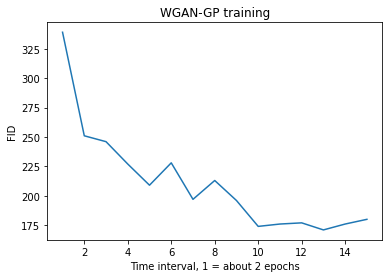

In [ ]:
# quick plot

from matplotlib import pyplot as plt

import seaborn as sns

y = [339,251,246,227,209,228,197,213,196, 174, 176, 177, 171, 176, 180]
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

ax = sns.lineplot(x = x, y = y)

ax.set_ylabel('FID')

ax.set_xlabel('Time interval, 1 = about 2 epochs')

ax.set_title("WGAN-GP training")

Text(0.5, 1.0, 'WGAN2-GP training')

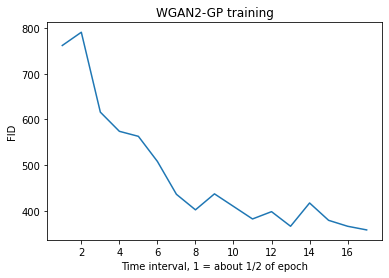

In [ ]:
# quick plot

from matplotlib import pyplot as plt

import seaborn as sns

y = [762,791,616,574,563,508,436,402,437,382,398, 366, 417, 379, 366, 358]
x = [1,2,3,4,5,6,7,8,9,11,12, 13, 14, 15, 16, 17]

ax = sns.lineplot(x = x, y = y)

ax.set_ylabel('FID')

ax.set_xlabel('Time interval, 1 = about 1/2 of epoch')

ax.set_title("WGAN2-GP training")